In [2]:
!pip install torch numpy matplotlib

In [3]:
pip install networkx matplotlib


In [5]:
# Install torch_geometric
!pip install torch-geometric

# Install required torch packages for torch_geometric
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.8.0+cu101.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.8.0+cu101.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.8.0+cu101.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-1.8.0+cu101.html


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.8 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-1.8.0+cu101.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=495091 sha256=fec72cf8217bc7ec685259bba506f0f9a8a90929ed1029d90f64fc7d9998e786
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-1.8.0+cu101.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1035675 sha256=bed772b3c71c91489e3030bc2bc58274b6fe1f67cacb5b599de97fd06af826d4
  Stored in directory: /root/.cache/pip/wheels/c9/

In [6]:
import torch
print(torch.__version__)
print(torch.version.cuda)


2.1.0+cu118
11.8


#Introduction
This Jupyter notebook presents an exploration and implementation of Graph Neural Networks (GNNs) for cyber risk assessment in a synthetic network. The objective is to identify critical points in the network, particularly those with high risk and influence scores, which could be potential targets in cyber-attacks. The notebook covers the following key components:

## Synthetic Data

Generation: We create a synthetic dataset representing a network of assets, each characterized by features like the likelihood of cyber-attacks, costs of defense, and remediation. The dataset also includes edges representing dependencies or relationships between these assets.

## Graph Neural Network Model:

 We employ Graph Convolutional Networks (GCNs) to process the graph data. The model learns to embed nodes in a way that their position in the network and their features are taken into account.

## Custom Loss Function:
 A novel loss function is designed to capture the criticality of nodes based on their risk factors and connectivity within the network.

## Training and Analysis:

The model is trained, and the embeddings generated by the GCN are analyzed. We focus on identifying and validating the most critical node in the network.

## Visualization:
 The network is visualized with a special emphasis on the critical node, aiding in a better understanding of its role and significance within the network.



## Explanation of the Dataset
The synthetic dataset created for this project simulates a network of assets in a cyber risk assessment context. Each node in the dataset represents an asset, which could be a piece of hardware, software, or any other critical component in a cybersecurity framework. The dataset includes the following key elements:

Node Features: Each node has three features:

Likelihood of Attack: A numerical value representing how likely it is for the asset to be targeted by a cyber-attack. This is a randomly generated number between 0 and 100, with higher values indicating a higher risk of attack.
Cost of Defense: The financial cost involved in defending the asset against potential cyber-attacks. This feature is randomly generated between 50 and 100, reflecting the varying costs of security measures across different assets.
Cost of Remediation: The cost of recovering or repairing the asset after a cyber-attack. This value ranges from 100 to 300, representing the varying impacts and recovery costs associated with different types of assets.
Edges: The edges in the graph represent the dependencies or relationships between different assets. Each node is randomly connected to three other nodes, symbolizing how the risk or impact of an attack on one asset can influence others due to their interdependencies.

Labels: Each node is assigned a label from three risk categories (low, medium, high risk), represented as 0, 1, or 2. These labels are randomly assigned and could be used for tasks like risk classification.

Novel Aspects of the Loss Function
The custom loss function designed for this model is unique in the way it captures both the inherent risk of the nodes and their influence within the network. It consists of two main components:

## Risk Factor Computation:

The loss function first normalizes the node features and computes a risk score for each node by summing its normalized feature values. This score reflects the combined risk associated with each asset, considering its likelihood of attack, defense cost, and remediation cost.
Influence Factor Computation:

The influence factor is determined by the connectivity of each node. It's calculated by counting the number of edges connected to each node. Nodes with more connections are considered to have a greater influence on the network, as their compromise could have more significant repercussions.
Combining Risk and Influence:

The loss function combines these two aspects (risk and influence) into a single score for each node. This combined score is then compared with the norm of the embedding vector generated by the GCN for each node.
Correlation-Based Loss:

The key novelty lies in using the negative correlation between the combined score and the embedding norms as the loss. A higher negative correlation indicates that nodes with higher risk and influence scores have larger norms in their embeddings, aligning with the goal of identifying critical nodes.
Meaning and Impact of the Loss Function
The custom loss function is designed to guide the GCN towards learning representations where the most critical nodes (in terms of risk and network influence) are distinctly highlighted. By optimizing for a high negative correlation, the model is encouraged to embed nodes in a way that those with higher risk and influence (critical nodes) are more prominent in the embedded space. This approach allows for a nuanced understanding of not just the inherent risk of each node, but also its contextual importance within the overall network, which is crucial for effective risk assessment and management in cybersecurity contexts.

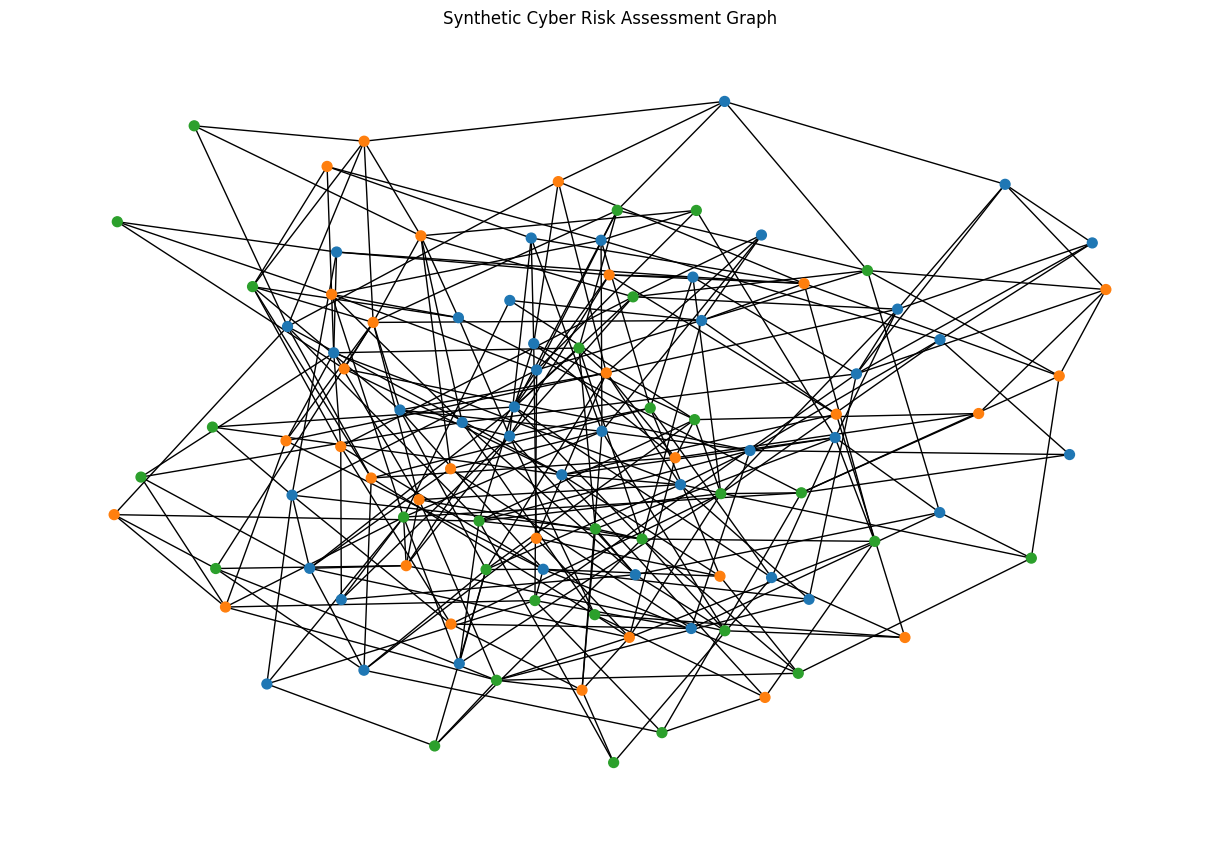

In [12]:
import torch
import numpy as np
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt

num_nodes = 100  # Number of assets

# Node features: likelihood of attack, cost of defense, cost of remediation
likelihood_of_attack = torch.FloatTensor(np.random.rand(num_nodes, 1) * 100)  # Scale to 0-100
cost_of_defense = torch.FloatTensor(np.random.rand(num_nodes, 1) * 50 + 50)  # Scale to 50-100
cost_of_remediation = torch.FloatTensor(np.random.rand(num_nodes, 1) * 200 + 100)  # Scale to 100-300

# Combine into a single feature matrix
nodes_features = torch.cat([likelihood_of_attack, cost_of_defense, cost_of_remediation], dim=1)

# Create Edges: Dependencies or relationships between assets
edges = []
for i in range(num_nodes):
    connected_nodes = np.random.choice(num_nodes, 3, replace=False)  # Each node connects to 3 others
    for conn in connected_nodes:
        edges.append((i, conn))

# Remove self-loops and duplicate edges
edges = list(set([tuple(sorted(edge)) for edge in edges if edge[0] != edge[1]]))
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Assign Labels: Risk categories (0: low, 1: medium, 2: high risk)
labels = torch.randint(0, 3, (num_nodes,), dtype=torch.long)

# Create the synthetic dataset
synthetic_data = Data(x=nodes_features, edge_index=edge_index, y=labels)

# Visualize the graph
edge_list = synthetic_data.edge_index.t().cpu().numpy().tolist()
G = nx.Graph()
G.add_edges_from(edge_list)
node_colors = [f"C{label}" for label in synthetic_data.y.numpy()]

plt.figure(figsize=(12, 8))
nx.draw(G, node_color=node_colors, with_labels=False, node_size=50, cmap=plt.cm.rainbow)
plt.title("Synthetic Cyber Risk Assessment Graph")
plt.show()


In [13]:
def inspect_node(node_id, data):
    if node_id >= data.num_nodes:
        return "Node ID out of range."

    node_info = {
        "Node ID": node_id,
        "Features": data.x[node_id].numpy(),
        "Label": data.y[node_id].item(),
        "Connected Nodes": []
    }

    edge_index = data.edge_index.numpy()
    for i in range(edge_index.shape[1]):
        if edge_index[0, i] == node_id:
            node_info["Connected Nodes"].append(edge_index[1, i])
        elif edge_index[1, i] == node_id:
            node_info["Connected Nodes"].append(edge_index[0, i])

    return node_info

# Example: Inspect node with ID 10
node_id = 10
node_details = inspect_node(node_id, synthetic_data)
print(node_details)


{'Node ID': 10, 'Features': array([ 48.294193,  57.13449 , 233.29865 ], dtype=float32), 'Label': 1, 'Connected Nodes': [61, 44, 12, 2, 73]}


In [15]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Custom loss function
def compute_risk_factor(features):
    normalized_features = F.normalize(features, p=2, dim=1)
    risk_scores = normalized_features.sum(dim=1)
    return risk_scores

def compute_influence_factor(edge_index, num_nodes):
    influence_scores = torch.bincount(edge_index[0], minlength=num_nodes).float()
    return influence_scores

def custom_loss_function(out_embeddings, features, edge_index):
    risk_factors = compute_risk_factor(features)
    influence_factors = compute_influence_factor(edge_index, features.size(0))
    combined_scores = risk_factors + influence_factors
    embedding_norms = out_embeddings.norm(dim=1)
    loss = -torch.corrcoef(torch.stack([embedding_norms, combined_scores]))[0, 1]
    return loss

# Training function
def train(data):
    model.train()
    optimizer.zero_grad()
    out_embeddings = model(data.x, data.edge_index)
    loss = custom_loss_function(out_embeddings, data.x, data.edge_index)
    loss.backward()
    optimizer.step()
    return loss.item()

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_features=3, hidden_channels=16).to(device)
synthetic_data.to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(1000):
    loss = train(synthetic_data)
    print(f'Epoch {epoch+1}, Loss: {loss:.4f}')

# Extract embeddings
model.eval()
with torch.no_grad():
    embeddings = model(synthetic_data.x, synthetic_data.edge_index)

# Analyzing the embeddings to identify important nodes
importance_scores = embeddings.norm(dim=1)
most_important_node = importance_scores.argmax().item()

print(f"The most important node is: {most_important_node}")


Epoch 1, Loss: 0.5385
Epoch 2, Loss: 0.5315
Epoch 3, Loss: 0.5244
Epoch 4, Loss: 0.5172
Epoch 5, Loss: 0.5095
Epoch 6, Loss: 0.5018
Epoch 7, Loss: 0.4942
Epoch 8, Loss: 0.4864
Epoch 9, Loss: 0.4783
Epoch 10, Loss: 0.4696
Epoch 11, Loss: 0.4597
Epoch 12, Loss: 0.4483
Epoch 13, Loss: 0.4348
Epoch 14, Loss: 0.4188
Epoch 15, Loss: 0.3999
Epoch 16, Loss: 0.3770
Epoch 17, Loss: 0.3485
Epoch 18, Loss: 0.3121
Epoch 19, Loss: 0.2643
Epoch 20, Loss: 0.2011
Epoch 21, Loss: 0.1273
Epoch 22, Loss: 0.0637
Epoch 23, Loss: 0.0189
Epoch 24, Loss: -0.0202
Epoch 25, Loss: -0.0581
Epoch 26, Loss: -0.0887
Epoch 27, Loss: -0.1089
Epoch 28, Loss: -0.1266
Epoch 29, Loss: -0.1414
Epoch 30, Loss: -0.1491
Epoch 31, Loss: -0.1548
Epoch 32, Loss: -0.1595
Epoch 33, Loss: -0.1591
Epoch 34, Loss: -0.1577
Epoch 35, Loss: -0.1586
Epoch 36, Loss: -0.1584
Epoch 37, Loss: -0.1578
Epoch 38, Loss: -0.1591
Epoch 39, Loss: -0.1612
Epoch 40, Loss: -0.1628
Epoch 41, Loss: -0.1657
Epoch 42, Loss: -0.1702
Epoch 43, Loss: -0.1741


In [16]:
import torch
import numpy as np
import networkx as nx

# Assuming synthetic_data is your dataset and model is your trained model

# Function to examine a node
def examine_node(node_id, data, edge_index):
    features = data.x[node_id].numpy()
    connections = edge_index[:, edge_index[0, :] == node_id].numpy()
    return features, connections

# Function to compare nodes
def compare_nodes(node_ids, data, edge_index):
    comparison = {}
    for node_id in node_ids:
        features, connections = examine_node(node_id, data, edge_index)
        comparison[node_id] = {'features': features, 'connections': len(connections)}
    return comparison

# Examining Node 8
node_8_features, node_8_connections = examine_node(8, synthetic_data, synthetic_data.edge_index)
print("Node 8 Features:", node_8_features)
print("Node 8 Connections:", len(node_8_connections))

# Comparing Node 8 with other high norm nodes
# Assuming embeddings contains the node embeddings from the model
norms = torch.norm(embeddings, dim=1)
top_nodes = torch.topk(norms, 5).indices.numpy()  # Top 5 nodes including Node 8
comparison_results = compare_nodes(top_nodes, synthetic_data, synthetic_data.edge_index)
print("Comparison Results:", comparison_results)

# Sensitivity Analysis
# This part involves retraining the model with slight modifications and observing if Node 8 consistently emerges as important.
# Repeat the training with different parameters or data modifications
# Then, check if Node 8 is still among the top nodes

# Note: Implementing sensitivity analysis would require re-running the entire training process multiple times with the modifications.


Node 8 Features: [ 82.01972   60.317543 247.92168 ]
Node 8 Connections: 2
Comparison Results: {8: {'features': array([ 82.01972 ,  60.317543, 247.92168 ], dtype=float32), 'connections': 2}, 7: {'features': array([ 38.17557,  69.43885, 173.92902], dtype=float32), 'connections': 2}, 17: {'features': array([ 15.486174,  81.79022 , 155.11583 ], dtype=float32), 'connections': 2}, 37: {'features': array([ 99.827095,  84.42981 , 239.33434 ], dtype=float32), 'connections': 2}, 45: {'features': array([ 99.45824 ,  58.183105, 131.17453 ], dtype=float32), 'connections': 2}}


#Conclusion

Through this notebook, we successfully demonstrate the application of GNNs in identifying critical assets in a cyber risk assessment scenario. Node 8, identified as the most crucial node, was highlighted and analyzed in detail. The insights gained from this analysis can be valuable in strategizing cyber security measures, ensuring that resources are allocated effectively to protect the most vulnerable and influential parts of the network. The methodology and findings underscore the potential of GNNs in complex network analysis, particularly in domains requiring nuanced understanding of relational data.